In [40]:
import numpy as np
from ifxAvian import Avian
from ifxAvian.RadarTypes import DeviceConfig
import time
import matplotlib.pyplot as plt

# using for bgt60tr13c


In [42]:
print("Radar SDK Version: " + Avian.get_version())
Avian.__file__

fs = 400
frame_time = 1/fs
num_samples_per_chirp = 512

device = Avian.Device()


Radar SDK Version: 3.3.1


In [43]:

# set device config
config = Avian.DeviceConfig(
    sample_rate_Hz=1_000_000,       # ADC sample rate of 1MHZ
    rx_mask=5,                      # activate RX1 and RX3
    tx_mask=1,                      # activate TX1
    if_gain_dB=33,                  # gain of 33dB
    tx_power_level=31,              # TX power level of 31
    start_frequency_Hz=58e9,        # start frequency of chirp: 58 Ghz
    end_frequency_Hz=63.5e9,        # end frequency of chirp: 63.5 GHz
    num_chirps_per_frame=1,         # 1 chirps per frame
    # 512 samples per chirp # higher number = higher range resolution
    num_samples_per_chirp=num_samples_per_chirp,
    chirp_repetition_time_s=0.001,  # 1ms, as long as higher than num_samples_per_chirp * 1 us
    frame_repetition_time_s=1/fs,  # 5ms, frame_Rate = 200Hz
    hp_cutoff_Hz=80_000,            # 80kHz cutoff frequency for high-pass filter
    aaf_cutoff_Hz=500_000,          # Anti-aliasinf cutoff frequency of 500kHz
    mimo_mode='off'                 # MIMO disabled
)
# config.frame_repetition_time_s = 10000000


In [44]:
device.set_config(config)
ts = time.time()
#currently sampling at around 10
timestamps = []
frameData = []
duration = fs*30
for frame_number in range(duration):
    frame = device.get_next_frame()
    #num_rx_antennas, num_chirps_per_frame, num_samples_per_chirp = np.shape(
    #    frame)
    mat = frame[0, :, :]
    ts_now = time.time()-ts
    # print(ts_now)
    # print(np.shape(frame))
    timestamps.append(ts_now)
    frameData.append(mat)

frameData = np.array(frameData)
timestamps = np.array(timestamps)

print(np.shape(frameData))
print(np.shape(timestamps))

(12000, 1, 512)
(12000,)


In [45]:
path = "F:\\UCSD\\Winter2023\\CSE237A\\FinalProj\\Github\\WaterSurfaceLevelSensing\\sampleData\\"
fn = 'data3.npz'

if True:
    np.savez(path+fn, frameData=frameData, timestamps=timestamps,fs=fs)

outfile = path+fn
npzfile = np.load(outfile)
frameData = npzfile['frameData']
timestamps = npzfile['timestamps']
fs = npzfile['fs']

# (100, 128, 64) 
# 100 frames, 128 chirps per frame, 64 adc samples per chirp
print(np.shape(frameData))
print(np.shape(timestamps))
print(np.shape(fs))

frameData = np.squeeze(frameData)
# frameData2 = np.sum(frameData, axis=1)
# print(np.shape(frameData2))

#mean normaliation to zero doppler nulling
frameData = frameData - np.mean(frameData, axis=1, keepdims=True)
print(np.shape(frameData))
fs=400

(12000, 1, 512)
(12000,)
()
(12000, 512)


(12000, 256)


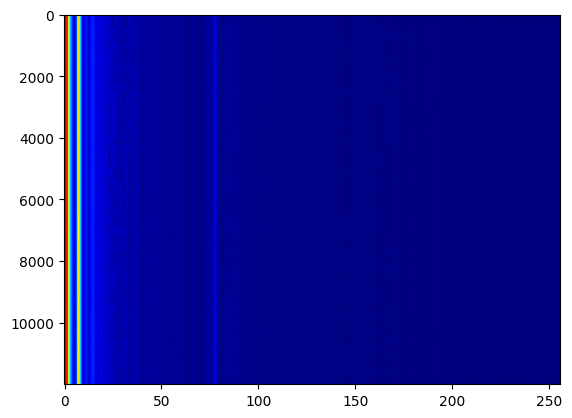

In [46]:
data = np.fft.fft(frameData, axis=1)
data = data[:, :int(data.shape[1]/2)]
print(np.shape(data))
plt.figure();
plt.imshow(np.abs(data), cmap=plt.cm.jet, aspect="auto")

# part = data[:, 3:10]
# rstData = np.abs(part)
# plt.figure()
# plt.imshow(rstData, cmap=plt.cm.jet, aspect="auto",label="AMP")

# part = data[:, 3:10]
# rstData = np.angle(part)
# plt.figure()
# plt.imshow(rstData, cmap=plt.cm.jet, aspect="auto", label = "PHASE")



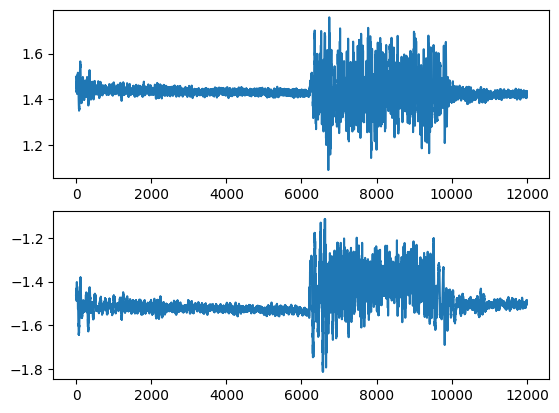

In [47]:
part = data[:, 6]
ampPart = np.abs(part)
phasePart = np.angle(part)
plt.subplot(2,1,1)
plt.plot(ampPart)
plt.subplot(2,1,2)
plt.plot(phasePart)
# part = data[:, 3:10]
# rstData = np.angle(part)
# plt.figure()
# plt.imshow(rstData, cmap=plt.cm.jet, aspect="auto", label = "PHASE")
